In [235]:
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters

from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask
from tqdm import tqdm

In [236]:
feature_size = 2
output_size = 3
hidden_size = 401
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\models\\only_dm_lif_refrac\\max_accuracy\\_lr_0.001_N_401_number_1990"
        )
    )
number_of_tasks = 100

In [312]:
dt = 1e-3
subgroup_finder = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0, 0.45)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


In [313]:
dt = 1e-3
subgroup_finder2 = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in tqdm(range(number_of_tasks)):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0.55, 1)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = model(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder2.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


In [314]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach())

In [315]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
strenght_second = answer_second * out_weights[2, :]
strenght_first_freq_second_out = answer_first * out_weights[2, :]
strenght_second_freq_first_out = answer_second * out_weights[1, :]

strenght_first_freq_fixation = fixation_first * out_weights[1, :]
strenght_second_freq_fixation = fixation_second * out_weights[2, :]
strenght_first_freq_second_out_fixation = fixation_first * out_weights[2, :]
strenght_second_freq_first_out_fixation = fixation_second * out_weights[1, :]

strenght_first_sort = sort_elemnts_by_another(strenght_first, strenght_first)
strenght_second_sort = sort_elemnts_by_another(strenght_first, strenght_second)
strenght_first_freq_second_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out
)
strenght_second_freq_first_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out
)

strenght_first_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_fixation
)
strenght_second_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_fixation
)
strenght_first_freq_second_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out_fixation
)
strenght_second_freq_first_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out_fixation
)

In [316]:
def plot_hist(data, c="b", alpha=1):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha)

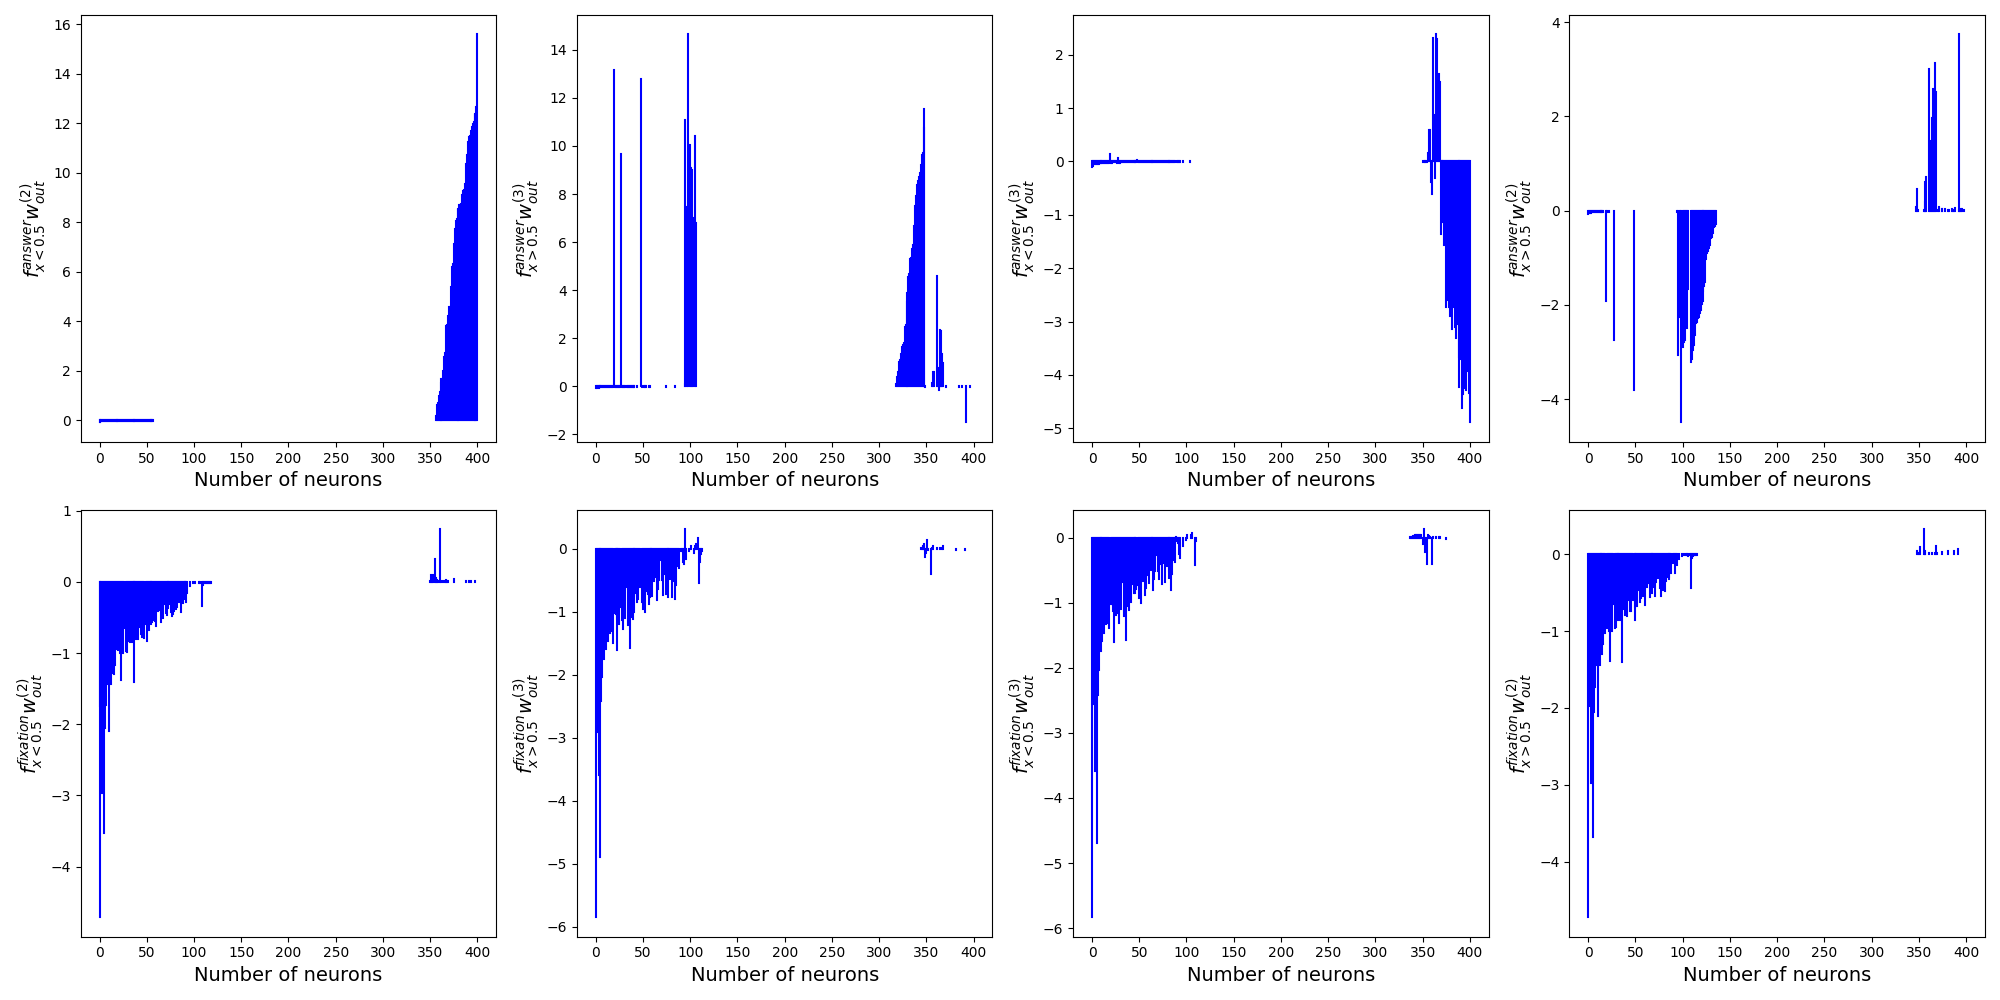

In [317]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))
plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_sort.numpy())

plt.subplot(243)
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_sort.numpy())

plt.subplot(244)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_sort.numpy())

plt.subplot(245)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_fixation_sort.numpy())

plt.subplot(246)
plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_fixation_sort.numpy())


plt.subplot(247)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_first_freq_second_out_fixation_sort.numpy())

plt.subplot(248)

plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plot_hist(strenght_second_freq_first_out_fixation_sort.numpy())
plt.tight_layout()
plt.savefig("freq_strenght.pdf")
plt.show()

In [318]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
# strenght_first = answer_first * out_weights[1, :]
fixation_first_sort = sort_elemnts_by_another(strenght_first, fixation_first)
fixation_second_sort = sort_elemnts_by_another(strenght_first, fixation_second)
answer_first_sort = sort_elemnts_by_another(strenght_first, answer_first)
answer_second_sort = sort_elemnts_by_another(strenght_first, answer_second)
out1_sort = sort_elemnts_by_another(strenght_first, out_weights[0, :])
out2_sort = sort_elemnts_by_another(strenght_first, out_weights[1, :])
out3_sort = sort_elemnts_by_another(strenght_first, out_weights[2, :])

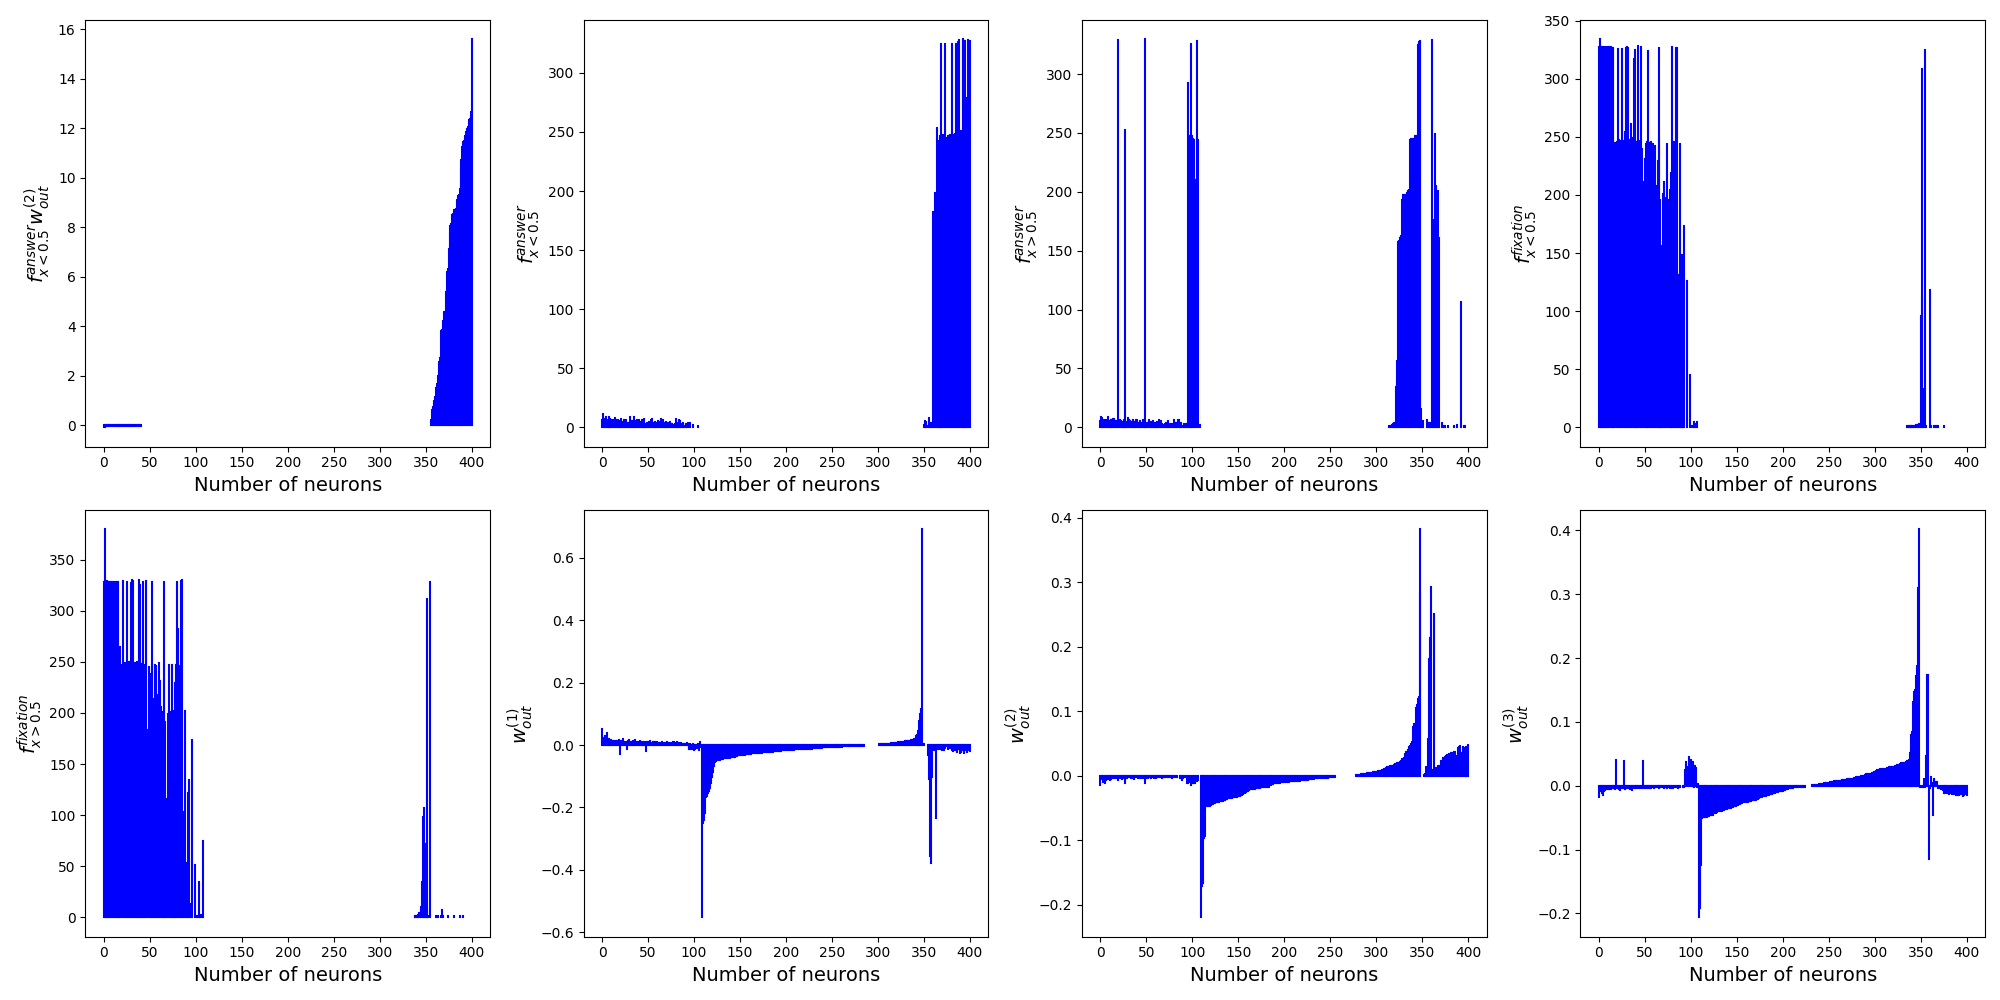

In [319]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
plt.savefig("freq.pdf")
plt.show()

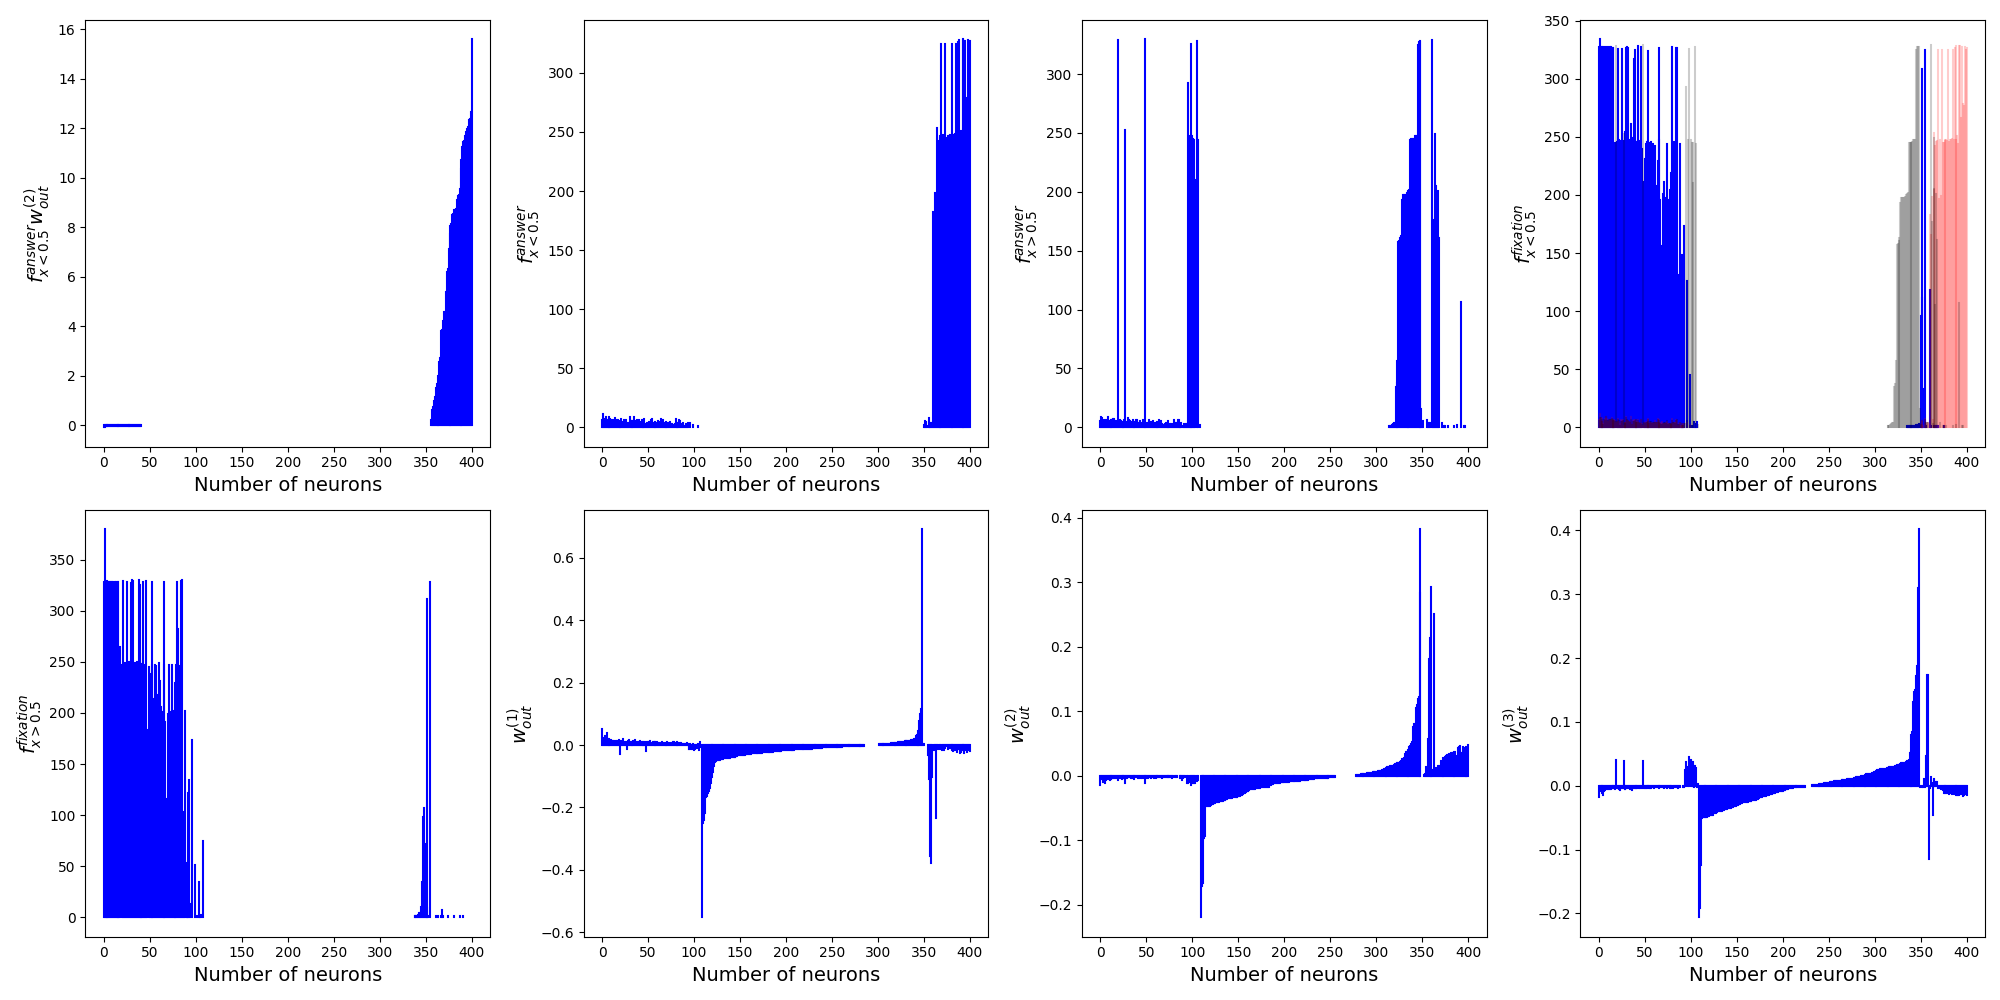

In [320]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plot_hist(answer_first_sort.numpy())


plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plot_hist(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plot_hist(fixation_first_sort.numpy())
plot_hist(answer_first_sort.numpy(), c="r", alpha=0.2)
plot_hist(answer_second_sort.numpy(), c="black", alpha=0.2)

plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plot_hist(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plot_hist(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plot_hist(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plot_hist(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
# plt.savefig("freq.pdf")
plt.show()

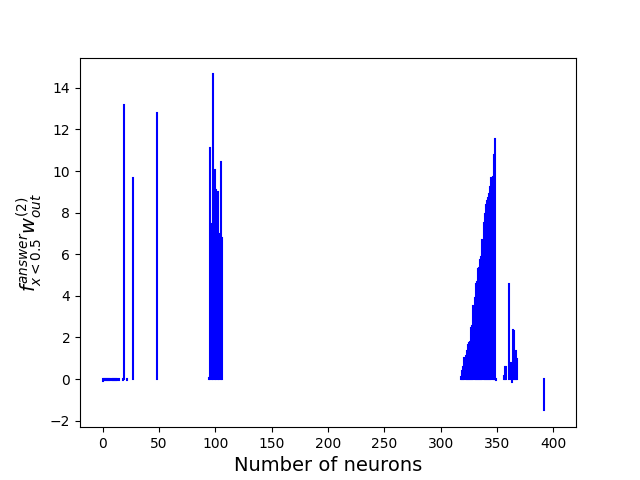

In [321]:
%matplotlib widget
plt.figure()
plot_hist(strenght_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.show()

In [322]:
for name, params in model.named_parameters():
    if name == "lif_refrac.recurrent_weights":
        rec_weights = torch.clone(params.detach())

list_numbers = [i for i in range(len(rec_weights))]

In [323]:
for name, params in model.named_parameters():
    if name == "lif_refrac.input_weights":
        input_weights = torch.clone(params.detach())

In [324]:
input_weights.shape

torch.Size([401, 2])

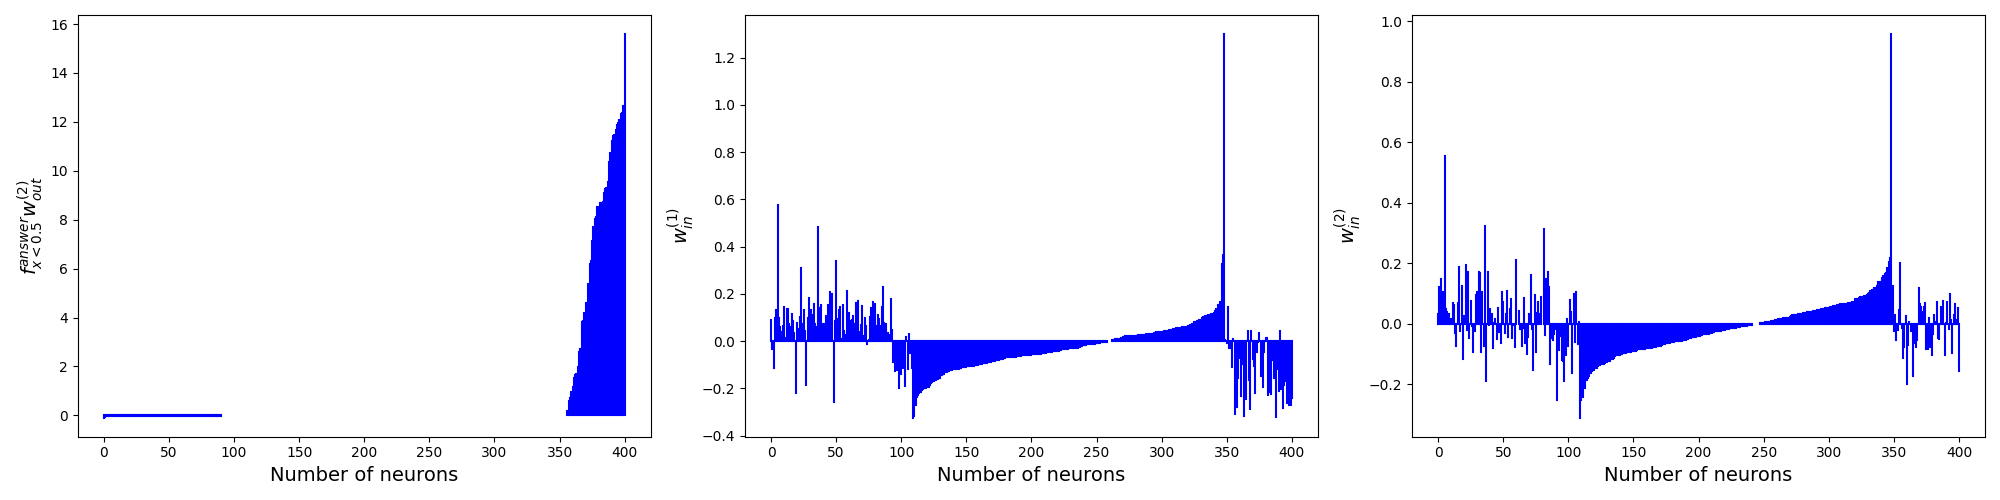

In [325]:
input_sort_1 = sort_elemnts_by_another(strenght_first, input_weights[:, 0])
input_sort_2 = sort_elemnts_by_another(strenght_first, input_weights[:, 1])

plt.figure(figsize=(20, 5))
plt.subplot(131)
plot_hist(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.subplot(132)
plot_hist(input_sort_1.numpy())
plt.ylabel(r"$w_{in}^{(1)}$")
plt.xlabel("Number of neurons")
plt.subplot(133)
plot_hist(input_sort_2.numpy())
plt.ylabel(r"$w_{in}^{(2)}$")
plt.xlabel("Number of neurons")
plt.tight_layout()
plt.savefig("w_in.pdf")
plt.show()

In [345]:
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)

In [346]:
rec_weights_sort = torch.zeros_like(rec_weights)

for i in range(len(list_numbers)):
    rec_weights_sort[i] = rec_weights[list_numbers_sort[i]]

C:\Users\slava\AppData\Local\Temp/ipykernel_12544/1909988294.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("rec_w.pdf", interpolation="None")


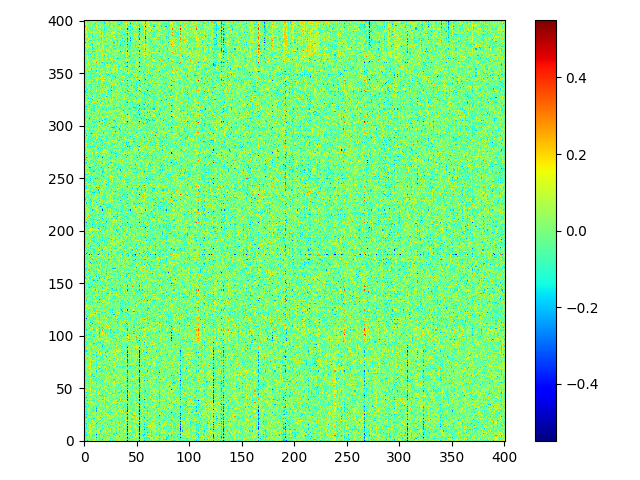

In [364]:
plt.figure()
plt.imshow(
    rec_weights_sort.numpy(),
    origin="lower",
    cmap="jet",
    vmin=-0.55,
    vmax=0.55,
    interpolation="nearest",
)
plt.colorbar()
plt.tight_layout()
plt.savefig("rec_w.pdf", interpolation="None")
plt.show()

# SELECTIVITY

In [254]:
dt = 1e-3

init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
values = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
Neurons_frequency_fixation = np.zeros((hidden_size, len(values)))
Neurons_frequency_answer = np.zeros((hidden_size, len(values)))
number_of_tasks = 100
for value_i in tqdm(range(len(values))):
    subgroup_finder_choose = SubgroupFinder(dt)
    for i in range(number_of_tasks):

        dmparams1 = DefaultParams("DMTask").generate_params()
        dmparams1["value"] = values[value_i]
        task = DMTask(dmparams1, mode="value")
        inputs, t_outputs = task.dataset(1)
        inputs = torch.from_numpy(inputs).type(torch.float32)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
        out, states = model(inputs, first_state)
        s = []
        for j in range(len(states)):
            s.append(states[j].lif.z)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        subgroup_finder_choose.compute_average_freq(
            [s], [inputs[:, 0, 0]], [out], [t_outputs]
        )
    Neurons_frequency_fixation[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[0].cpu()
    ).numpy()
    Neurons_frequency_answer[:, value_i] += (
        subgroup_finder_choose.get_average_freq()[1].cpu()
    ).numpy()

100%|██████████| 10/10 [06:40<00:00, 40.08s/it]


In [255]:
Neurons_frequency_fixation_copy = torch.from_numpy(Neurons_frequency_fixation).type(
    torch.float
)
Neurons_frequency_answer_copy = torch.from_numpy(Neurons_frequency_answer).type(
    torch.float
)

In [260]:
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation_copy)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_first.pdf")
plt.show()
plt.close()
Neurons_frequency_fixation_sort = torch.zeros_like(Neurons_frequency_fixation)

list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_fixation_sort[i] = Neurons_frequency_fixation[
        list_numbers_sort[i]
    ]


plt.imshow(Neurons_frequency_fixation_sort, aspect="auto", origin="lower")
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_fixation_sort_second.pdf")
plt.show()
plt.close()

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

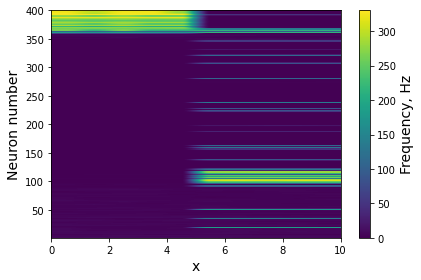

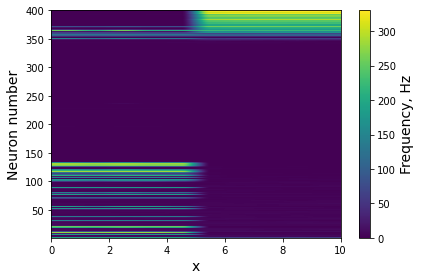

In [ ]:
# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_first.pdf")
plt.show()
plt.close()

# Neurons_frequency_answer = torch.from_numpy(Neurons_frequency_answer).type(torch.float)
Neurons_frequency_answer_sort = torch.zeros_like(Neurons_frequency_answer)
list_numbers = [i for i in range(len(rec_weights))]
list_numbers_sort = sort_elemnts_by_another(strenght_second, list_numbers)
for i in range(len(list_numbers)):
    Neurons_frequency_answer_sort[i] = Neurons_frequency_answer[list_numbers_sort[i]]
plt.figure()
plt.imshow(
    Neurons_frequency_answer_sort, aspect="auto", origin="lower", extent=[0, 10, 1, 401]
)
plt.colorbar(label="Frequency, Hz")
plt.xlabel("x")
plt.ylabel("Neuron number")
plt.tight_layout()
plt.savefig("Neurons_frequency_answer_sort_second.pdf")
plt.show()
plt.close()

In [ ]:
Neurons_frequency_answer_sort.shape

torch.Size([401, 10])

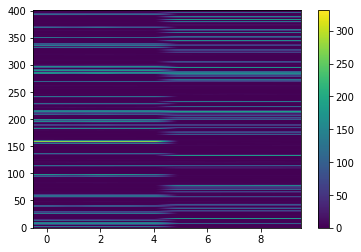

In [ ]:
plt.imshow(Neurons_frequency_answer, aspect="auto", origin="lower")
plt.colorbar()

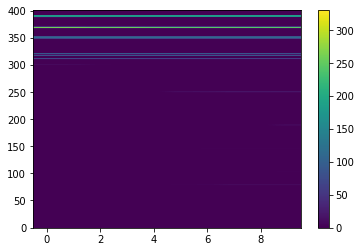

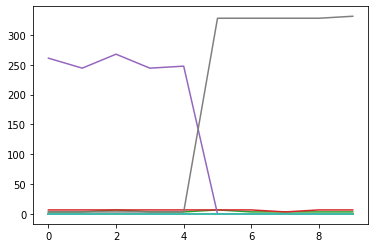

In [ ]:
for i in range(10, 20):
    plt.plot(Neurons_frequency_answer_copy[i, :])

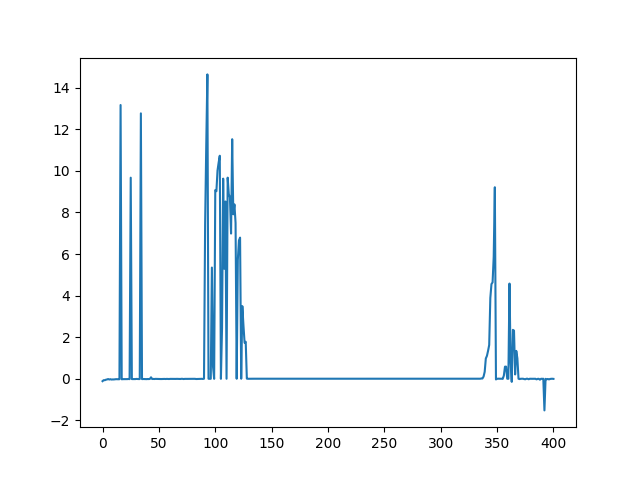

In [ ]:
plt.figure()
plt.plot(strenght_second_sort.numpy())

In [335]:
rec_weights_sort
A_1_answer = [*torch.where(strenght_first > 2)[0].type(torch.int).numpy()]
A_2_answer = [*torch.where(strenght_second > 2)[0].type(torch.int).numpy()]

A_fix = [*torch.where(fixation_first > 20)[0].type(torch.int).numpy()]
# A_1_answer = list(set(A_1_answer) - set(A_fix))
# A_2_answer = list(set(A_2_answer) - set(A_fix))
set_full_neurons = set([i for i in range(hidden_size)])
active_neurons = set((*A_1_answer, *A_2_answer, *A_fix))
usless_neurons = list(set_full_neurons - active_neurons)
len(usless_neurons)

230

In [338]:
input_1_to_fix = torch.mean(input_weights[:, 0][A_fix])
input_2_to_fix = torch.mean(input_weights[:, 1][A_fix])
input_1_to_1_answ = torch.mean(input_weights[:, 0][A_1_answer])
input_2_to_1_answ = torch.mean(input_weights[:, 1][A_1_answer])
input_1_to_2_answ = torch.mean(input_weights[:, 0][A_2_answer])
input_2_to_2_answ = torch.mean(input_weights[:, 1][A_2_answer])
input_1_to_usles = torch.mean(input_weights[:, 0][usless_neurons])
input_2_to_usles = torch.mean(input_weights[:, 1][usless_neurons])

answ_1_to_fix = torch.mean(rec_weights[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.mean(rec_weights[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.mean(rec_weights[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.mean(rec_weights[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.mean(rec_weights[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.mean(rec_weights[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.mean(out_weights[0, :][A_fix])
fix_to_out_1 = torch.mean(out_weights[1, :][A_fix])
fix_to_out_2 = torch.mean(out_weights[2, :][A_fix])

answ_1_to_out0 = torch.mean(out_weights[0, :][A_1_answer])
answ_2_to_out0 = torch.mean(out_weights[0, :][A_2_answer])


answ_1_to_out1 = torch.mean(out_weights[1, :][A_1_answer])
answ_1_to_out2 = torch.mean(out_weights[2, :][A_1_answer])
answ_2_to_out1 = torch.mean(out_weights[1, :][A_2_answer])
answ_2_to_out2 = torch.mean(out_weights[2, :][A_2_answer])

fix_to_usless = torch.mean(rec_weights[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.mean(rec_weights[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.mean(rec_weights[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.mean(out_weights[0, :][usless_neurons])
usless_to_out_2 = torch.mean(out_weights[1, :][usless_neurons])
usless_to_out_3 = torch.mean(out_weights[2, :][usless_neurons])

usless_to_fix = torch.mean(rec_weights[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.mean(rec_weights[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.mean(rec_weights[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.mean(rec_weights[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.mean(rec_weights[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.mean(rec_weights[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.mean(rec_weights[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> answ 1: {input_1_to_1_answ}")
print(f"in_2 -> answ 1: {input_2_to_1_answ}")
print(f"in_1 -> answ 2: {input_1_to_2_answ}")
print(f"in_2 -> answ 2: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")

print(f"answ 1 -> fix: {answ_1_to_fix}")
print(f"answ 2 -> fix: {answ_2_to_fix}")

print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: 0.0990825742483139
in_2 -> fix: 0.03017239086329937
in_1 -> answ 1: -0.14247795939445496
in_2 -> answ 1: -0.006107870489358902
in_1 -> answ 2: -0.1036631166934967
in_2 -> answ 2: -0.057770632207393646
in_1 -> usles: -0.02687947265803814
in_2 -> usles: -0.007982317358255386
fix -> answ 1: 0.005908918101340532
fix -> answ 2: 0.001916549983434379
fix -> usles 1: -0.01622748002409935
answ_1 -> usles: -0.026904305443167686
answ_2 -> usles: -0.025664983317255974
answ 1 -> answ 2: -0.01081548910588026
answ 2 -> answ 1: -0.012669149786233902
usless -> fix: -0.005023601930588484
usless -> answ 1: 0.004224678967148066
usless -> answ 2: 0.010363529436290264
fix -> out 1: 0.009569527581334114
fix -> out 2: -0.002687007887288928
fix -> out 3: -0.003371398663148284
answ 1 -> fix: -0.012904232367873192
answ 2 -> fix: -0.013441725634038448
answ 1 -> out 1: -0.013013559393584728
answ 2 -> out 1: -0.011198214255273342
answ 1 -> out 2: 0.031573161482810974
answ 2 -> out 2: -0.007101877126842

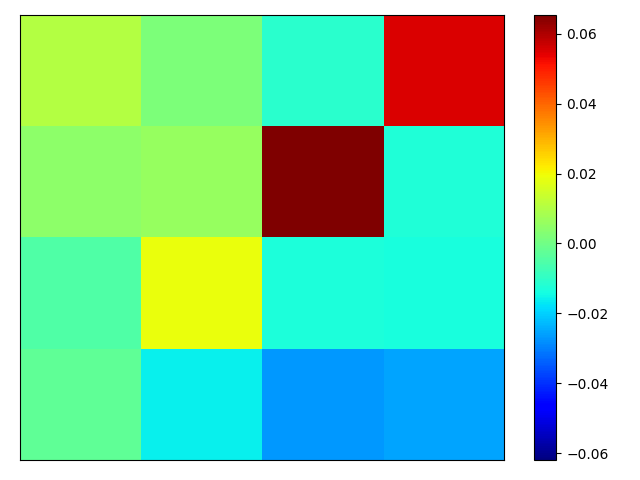

In [352]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="jet",
    vmin=-0.062,
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()

In [311]:
input_1_to_fix = torch.sum(input_weights[:, 0][A_fix])
input_2_to_fix = torch.sum(input_weights[:, 1][A_fix])
input_1_to_1_answ = torch.sum(input_weights[:, 0][A_1_answer])
input_2_to_1_answ = torch.sum(input_weights[:, 1][A_1_answer])
input_1_to_2_answ = torch.sum(input_weights[:, 0][A_2_answer])
input_2_to_2_answ = torch.sum(input_weights[:, 1][A_2_answer])
input_1_to_usles = torch.sum(input_weights[:, 0][usless_neurons])
input_2_to_usles = torch.sum(input_weights[:, 1][usless_neurons])

answ_1_to_fix = torch.sum(rec_weights[:, A_1_answer][A_fix, :])
answ_2_to_fix = torch.sum(rec_weights[:, A_2_answer][A_fix, :])
fix_to_answ_1 = torch.sum(rec_weights[:, A_fix][A_1_answer, :])
fix_to_answ_2 = torch.sum(rec_weights[:, A_fix][A_2_answer, :])

answ_1_to_answ_2 = torch.sum(rec_weights[:, A_1_answer][A_2_answer, :])
answ_2_to_answ_1 = torch.sum(rec_weights[:, A_2_answer][A_1_answer, :])

fix_to_out_0 = torch.sum(out_weights[0, :][A_fix])
fix_to_out_1 = torch.sum(out_weights[1, :][A_fix])
fix_to_out_2 = torch.sum(out_weights[2, :][A_fix])

answ_1_to_out0 = torch.sum(out_weights[0, :][A_1_answer])
answ_2_to_out0 = torch.sum(out_weights[0, :][A_2_answer])


answ_1_to_out1 = torch.sum(out_weights[1, :][A_1_answer])
answ_1_to_out2 = torch.sum(out_weights[2, :][A_1_answer])
answ_2_to_out1 = torch.sum(out_weights[1, :][A_2_answer])
answ_2_to_out2 = torch.sum(out_weights[2, :][A_2_answer])

fix_to_usless = torch.sum(rec_weights[:, A_fix][usless_neurons, :])
answ_1_to_usless = torch.sum(rec_weights[:, A_1_answer][usless_neurons, :])
answ_2_to_usless = torch.sum(rec_weights[:, A_2_answer][usless_neurons, :])


usless_to_out_1 = torch.sum(out_weights[0, :][usless_neurons])
usless_to_out_2 = torch.sum(out_weights[1, :][usless_neurons])
usless_to_out_3 = torch.sum(out_weights[2, :][usless_neurons])

usless_to_fix = torch.sum(rec_weights[:, usless_neurons][A_fix, :])
usless_to_answ_1 = torch.sum(rec_weights[:, usless_neurons][A_1_answer, :])
usless_to_answ_2 = torch.sum(rec_weights[:, usless_neurons][A_2_answer, :])

fix_to_fix = torch.sum(rec_weights[A_fix, :][:, A_fix])
answ_1_to_answ_1 = torch.sum(rec_weights[:, A_1_answer][A_1_answer, :])
answ_2_to_answ_2 = torch.sum(rec_weights[:, A_2_answer][A_2_answer, :])
usless_to_usless = torch.sum(rec_weights[:, usless_neurons][usless_neurons, :])

print(f"in_1 -> fix: {input_1_to_fix}")
print(f"in_2 -> fix: {input_2_to_fix}")
print(f"in_1 -> first answ: {input_1_to_1_answ}")
print(f"in_2 -> first answ: {input_2_to_1_answ}")
print(f"in_1 -> second answ: {input_1_to_2_answ}")
print(f"in_2 -> second answ: {input_2_to_2_answ}")
print(f"in_1 -> usles: {input_1_to_usles}")
print(f"in_2 -> usles: {input_2_to_usles}")

print(f"fix -> answ 1: {fix_to_answ_1}")
print(f"fix -> answ 2: {fix_to_answ_2}")
print(f"fix -> usles 1: {fix_to_usless}")
print(f"answ_1 -> usles: {answ_1_to_usless}")
print(f"answ_2 -> usles: {answ_2_to_usless}")
print(f"answ 1 -> answ 2: {answ_1_to_answ_2}")
print(f"answ 2 -> answ 1: {answ_2_to_answ_1}")

print(f"usless -> fix: {usless_to_fix}")
print(f"usless -> answ 1: {usless_to_answ_1}")
print(f"usless -> answ 2: {usless_to_answ_2}")
print(f"fix -> out 1: {fix_to_out_0}")
print(f"fix -> out 2: {fix_to_out_1}")
print(f"fix -> out 3: {fix_to_out_2}")

print(f"answ 1 -> fix: {answ_1_to_fix}")
print(f"answ 2 -> fix: {answ_2_to_fix}")

print(f"answ 1 -> out 1: {answ_1_to_out0}")
print(f"answ 2 -> out 1: {answ_2_to_out0}")
print(f"answ 1 -> out 2: {answ_1_to_out1}")
print(f"answ 2 -> out 2: {answ_2_to_out1}")
print(f"answ 1 -> out 3: {answ_1_to_out2}")
print(f"answ 2 -> out 3: {answ_2_to_out2}")
print(f"usless -> out 1: {usless_to_out_1}")
print(f"usless -> out 2: {usless_to_out_2}")
print(f"usless -> out 3: {usless_to_out_3}")

print(f"fix -> fix: {fix_to_fix}")
print(f"answ 1 -> answ 1: {answ_1_to_answ_1}")
print(f"answ 2 -> answ 2: {answ_2_to_answ_2}")
print(f"usless -> usless: {usless_to_usless}")

in_1 -> fix: 9.809174537658691
in_2 -> fix: 2.9870667457580566
in_1 -> first answ: -5.670220375061035
in_2 -> first answ: -0.38698089122772217
in_1 -> second answ: -4.619972229003906
in_2 -> second answ: -2.3345112800598145
in_1 -> usles: -6.006985664367676
in_2 -> usles: -1.8494592905044556
fix -> answ 1: 29.85108757019043
fix -> answ 2: 5.934572219848633
fix -> usles 1: -366.1841125488281
answ_1 -> usles: -257.4415283203125
answ_2 -> usles: -286.68353271484375
answ 1 -> answ 2: 3.4819602966308594
answ 2 -> answ 1: -2.0981130599975586
usless -> fix: -115.56353759765625
usless -> answ 1: 42.8087272644043
usless -> answ 2: 94.44204711914062
fix -> out 1: 0.9473832249641418
fix -> out 2: -0.2660137712955475
fix -> out 3: -0.33376845717430115
answ 1 -> fix: -52.14338302612305
answ 2 -> fix: -58.37235641479492
answ 1 -> out 1: -0.47063148021698
answ 2 -> out 1: -0.44448554515838623
answ 1 -> out 2: 1.16309654712677
answ 2 -> out 2: -0.16960318386554718
answ 1 -> out 3: -0.30511364340782166

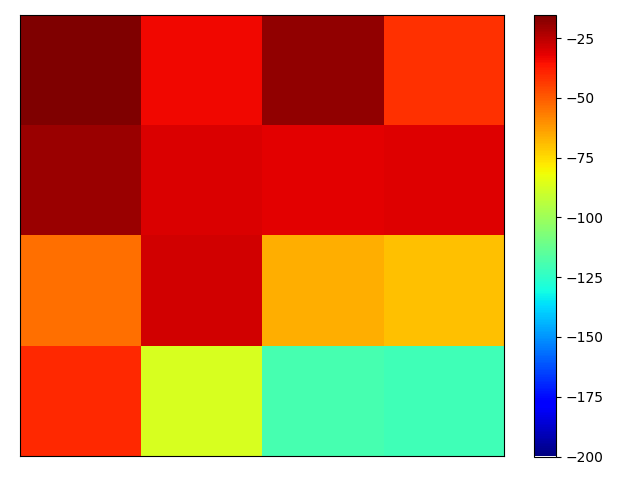

In [302]:
Matrix_blocks = np.zeros((4, 4))
Matrix_blocks[0, 0] = usless_to_usless
Matrix_blocks[1, 1] = fix_to_fix
Matrix_blocks[2, 2] = answ_1_to_answ_1
Matrix_blocks[3, 3] = answ_2_to_answ_2

Matrix_blocks[0, 1] = usless_to_fix
Matrix_blocks[0, 2] = usless_to_answ_1
Matrix_blocks[0, 3] = usless_to_answ_2

Matrix_blocks[1, 0] = fix_to_usless
Matrix_blocks[1, 2] = fix_to_answ_1
Matrix_blocks[1, 3] = fix_to_answ_2

Matrix_blocks[2, 0] = answ_1_to_usless
Matrix_blocks[2, 1] = answ_1_to_fix
Matrix_blocks[2, 3] = answ_1_to_answ_2
Matrix_blocks[3, 0] = answ_2_to_usless
Matrix_blocks[3, 1] = answ_2_to_fix
Matrix_blocks[3, 2] = answ_2_to_answ_1

plt.figure()
plt.imshow(
    Matrix_blocks.T,
    aspect="auto",
    origin="lower",
    interpolation="nearest",
    cmap="jet",
    vmin=-200,
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.savefig("blocks.pdf")

plt.show()

In [ ]:
rec_weights_sort[A_fix, :][:, A_1_answer]

tensor([[ 0.0770, -0.0246, -0.0348,  ..., -0.0021,  0.1356, -0.0090],
        [-0.0263,  0.0502,  0.0964,  ...,  0.1729,  0.1409, -0.0542],
        [-0.1964,  0.0474, -0.0186,  ...,  0.0247,  0.0156, -0.0760],
        ...,
        [-0.0923, -0.0199,  0.0407,  ...,  0.0000, -0.0594, -0.0625],
        [-0.1891, -0.1017,  0.0157,  ...,  0.0857,  0.0000, -0.0092],
        [ 0.1614,  0.0748,  0.0047,  ..., -0.0162, -0.1186, -0.0360]])

In [ ]:
rec_weights_sort[A_fix, :].shape

torch.Size([130, 401])